In [247]:
%pwd

'C:\\Users\\machine_saver\\Downloads\\data_clips'

Setting up your TwinProx application settings.
1. Assign the PHASE  REFERENCE application to the 1st board (any channel) that sees a notch on a shaft;
2. Adjust the  PHASE  REFERENCE thresholds to match your test setup.
3. On WEB GUI connect to  the 1st  board. You will see the notch gaps on the charts.
4. Assign the RADIAL VIBRATION  application to the 2nd  board (both  channels);
5. Connect both boards using BLUE & YELLOW terminals
6. On WEB GUI connect to  the 2nd  board. You will see the same synchronized notch gaps on the charts.

I have attached the doc that explains how to deal with applications.
Important note. The latest WEB GUI provides the complete interface to deal with the applications.

# Libraries

In [248]:
from datetime import datetime
import json
import math
import minimalmodbus
import numpy as np
import os
import plotly.graph_objects as go
from scipy.fftpack import fft
import serial.tools.list_ports
import time

# Tools

## Data Functions

In [249]:
def save_clip_json(dictionary):
    """Takes a python dictionary of unprocessed analysis data, turns it into a serialized JSON 
    and saves it to a file with the associated sensor serial number and the timestamp of the collection.
    Data size (assuming a minified JSON file --- no spaces) for 49,152 samples (16,384 samples_per_axis * 3 axes) is 289kB. 
    Therefore, using 1GB of storage could store upto 3460 data clips with this number of samples."""
    notebook_folder = os.getcwd()
    new_folder = "\data_clips"
    data_folder = notebook_folder+new_folder

    print(f"notebook directory: {notebook_folder} to data directory: {data_folder}\n")

    # Check if the directory exists, and create it if it doesn't
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    if(os.getcwd()!=data_folder):
        print(f"moving from notebook directory: {notebook_folder} to data directory: {data_folder}\n")
        # Change the current working directory to the new directory
        os.chdir(data_folder)
    else:
        print(f"current directory: {notebook_folder} is the data directory: {data_folder}\n")
        pass

    encoded_json = json.JSONEncoder().encode(dictionary)
    file_name = str(dictionary["serial_number"]) + \
        "_"+str(dictionary["unix_timestamp"])+".json"
    f = open(file_name, "w")
    f.write(encoded_json)
    f.close()

    # Change the current working directory to the notebook directory
    print(f"moving back from data directory: {data_folder} to notebook directory: {notebook_folder}\n")
    os.chdir(notebook_folder)
    return(None)

## COM Port Finder

In [253]:
ports = list(serial.tools.list_ports.comports())
if len(ports) == 0:
    print('Please Plug A USB to RS485 Serial Converter in to Computer')
else:
    for p in ports:
        print(p)

COM6 - Standard Serial over Bluetooth link (COM6)
COM4 - Standard Serial over Bluetooth link (COM4)
COM9 - USB Serial Port (COM9)
COM3 - Standard Serial over Bluetooth link (COM3)
COM8 - Standard Serial over Bluetooth link (COM8)


## Slave Finder

In [254]:
# from tqdm.notebook import tqdm
# import minimalmodbus

# class ModbusScanner:
#     def __init__(self, port, baudrate=115200, timeout=1.0):
#         self.port = port
#         self.baudrate = baudrate
#         self.timeout = timeout
#         self.instrument = None

#     def setup_instrument(self, slave_address):
#         self.instrument = minimalmodbus.Instrument(self.port, slave_address)
#         self.instrument.serial.baudrate = self.baudrate
#         self.instrument.serial.bytesize = 8
#         self.instrument.serial.parity = "N"
#         self.instrument.serial.stopbits = 1
#         self.instrument.serial.timeout = self.timeout
#         self.instrument.close_port_after_each_call = True
#         self.instrument.mode = minimalmodbus.MODE_RTU
#         self.instrument.clear_buffers_before_each_transaction = True

#     def scan_slave_address(self, slave_address):
#         try:
#             self.setup_instrument(slave_address)
#             result = self.instrument.read_long(26, functioncode=3)
#             print(f"Slave {slave_address} Found: {result}")
#             return True
#         except Exception as e:
#             print(f"No Response from Slave: {slave_address} - Error: {e}")
#             return False

#     def scan_all_slave_addresses(self):
#         for slave_address in tqdm(range(256), desc="Scanning Slave Addresses"):
#             self.scan_slave_address(slave_address)

# if __name__ == "__main__":
#     scanner = ModbusScanner(port='COM9')
#     scanner.scan_all_slave_addresses()

# Sensor Communication Setup

## Slave Address and COM Port

In [255]:
# You can use the COM Port Finder Tool to see connected + available ports.
# Linux Port Style: "/dev/ttyUSB0"
# Windows Port Syle: "COM1"
# Select the port which has an RS485 converter or TriVibe simulator.
# The default slave address of each TriVibe is the last 2 digits of the serial number.

twinprox = minimalmodbus.Instrument(port='COM9', slaveaddress=2)

In [256]:
# Update Modbus serial communication settings
twinprox.serial.port
twinprox.address
twinprox.serial.baudrate = 115200
twinprox.serial.bytesize = 8
twinprox.serial.parity = "N"
twinprox.serial.stopbits = 1
twinprox.serial.timeout = 0.10
twinprox.close_port_after_each_call = True # Helps communication for Windows Devices (can be set to false on many Linux devices)
twinprox.mode = minimalmodbus.MODE_RTU
twinprox.clear_buffers_before_each_transaction = True

# Export Analysis Data Storage (JSON)

## Exported Data Example

In [257]:
# example_json = {
#    "serial_number": 21030569,
#    "distance_a":  10.13,
#    "distance_b":  11.15,
#    "displacement_a":  0.02,
#    "displacement_b":  0.01,
#    "voltage_a":  0.07104,
#    "voltage_b":  0.06940,
#    "clip_size": 3600,
#    "unix_timestamp": 1644420691,
#    "channel_a_raw":[32768,32785,32792,32765,32755],
#    "channel_b_raw":[32770,32762,32760,32775,32780],
# }

## Notebook Analysis Data Container (Convert to JSON to Export)

In [258]:
# A simple dictionary to hold important processing information for an analysis clip
# Use the helper function "save_clip_json(dictionary)" to write the dictionary file to your PC after collecting a data clip.

data = {}

# TriVibe Metadata

## Serial Number

In [259]:
data["serial_number"] = twinprox.read_long(26, functioncode=3)
print(data["serial_number"])

2408302


## Firmware Revision

In [260]:
sensor_revision = twinprox.read_register(0, functioncode=3)
print('Sensor Software Revision:', sensor_revision-768)

Sensor Software Revision: 2829


## Overalls

In [261]:
distance_a = twinprox.read_register(176, functioncode=3)
print("distance_a: ", distance_a/100.0, "mils")

distance_b = twinprox.read_register(177, functioncode=3)
print("distance_b: ", distance_b/100.0, "mils")

displacement_a = twinprox.read_register(178, functioncode=3)
print("displacement_a: ", displacement_a/100.0, "mils")

displacement_b = twinprox.read_register(179, functioncode=3)
print("displacement_b: ", displacement_b/100.0, "mils")

voltage_a = twinprox.read_float(190, functioncode=3)
print("voltage_a: ", voltage_a, "volts")

voltage_b = twinprox.read_float(192, functioncode=3)
print("voltage_b: ", voltage_b, "volts")

distance_a:  14.03 mils
distance_b:  1.0 mils
displacement_a:  0.0 mils
displacement_b:  0.0 mils
voltage_a:  0.0690453052520752 volts
voltage_b:  4.921520233154297 volts


In [262]:
data["machine_speed"] = twinprox.read_register(372, functioncode=3)
print(data["machine_speed"])

60


# Dynamic Data Clip (Single TwinProx w/o Phase Reference Probe)

### Capture Parameters Setup

In [263]:
modbus_channel_a = 1
modbus_channel_b = 2
modbus_channel_ab = 3

twinprox.write_register(32, modbus_channel_ab)

### Trigger Dataclip Capture + Save Timestamp

In [264]:
twinprox.write_register(33, 1)
data["unix_timestamp"] = int(str(time.time())[slice(10)])
human_readable_timestamp = datetime.fromtimestamp(data["unix_timestamp"])
print(human_readable_timestamp)

2024-09-13 12:39:02


### Monitor Capture Engine Status

In [265]:
capture_engine_status = twinprox.read_register(34, functioncode=3)
print('capture_engine_status: '+str(capture_engine_status))

# wait for data capture on the Tri-Vibe to complete
while capture_engine_status == 2:
    capture_engine_status = twinprox.read_register(34, functioncode=3)
    print('capture_engine_status: '+str(capture_engine_status))
    time.sleep(2)

# show capture engine is complete (capturing done)
capture_engine_status = twinprox.read_register(34, functioncode=3)
print('capture_engine_status: '+str(capture_engine_status))

capture_engine_status: 2
capture_engine_status: 2
capture_engine_status: 2
capture_engine_status: 1
capture_engine_status: 0


Identify clip size by reading 16-bit MODBUS HIGH SIZE CAPTURE REGISTER 40037 and 16-bit MODBUS LOW SIZE CAPTURE REGISTER 40038.

In [266]:
clip_size = twinprox.read_long(36, functioncode=3)
print('clip_size: '+str(clip_size))

clip_size: 3600


### Retrieve RAW ADC Data 

In [267]:
from tqdm.notebook import tqdm

# Initialize your variables
raw_data = []

# Create a tqdm progress bar
with tqdm(total=clip_size, desc="Collecting Data", unit="samples") as pbar:
    while len(raw_data) < clip_size:
        read_set = twinprox.read_registers(49, 123, functioncode=3)
        read_set.pop(0)
        
        # Scale the values by dividing each by 100
        scaled_set = [value / 100 for value in read_set]
        
        raw_data.extend(scaled_set)
        
        # Update the progress bar
        pbar.update(len(scaled_set))

# Your existing code to process the collected data
raw_sliced = raw_data[0:clip_size]
data['channel_a'] = raw_sliced[0:int(clip_size/2)]
data['channel_b'] = raw_sliced[int(clip_size/2):int(clip_size)]

### Save RAW Data Clip into JSON File

In [269]:
save_clip_json(data)

notebook directory: C:\Users\machine_saver\Downloads\data_clips to data directory: C:\Users\machine_saver\Downloads\data_clips\data_clips

moving from notebook directory: C:\Users\machine_saver\Downloads\data_clips to data directory: C:\Users\machine_saver\Downloads\data_clips\data_clips

moving back from data directory: C:\Users\machine_saver\Downloads\data_clips\data_clips to notebook directory: C:\Users\machine_saver\Downloads\data_clips



In [270]:
RPM = data["machine_speed"]
RPS = RPM/60.0
revolutions = 5
samples_per_rev = 360
samples_per_five = samples_per_rev*5
samples_per_second = RPS*samples_per_rev
time_of_five_s = samples_per_five/samples_per_second 
time_of_five_ms = time_of_five_s*1000

### Plot RAW Data

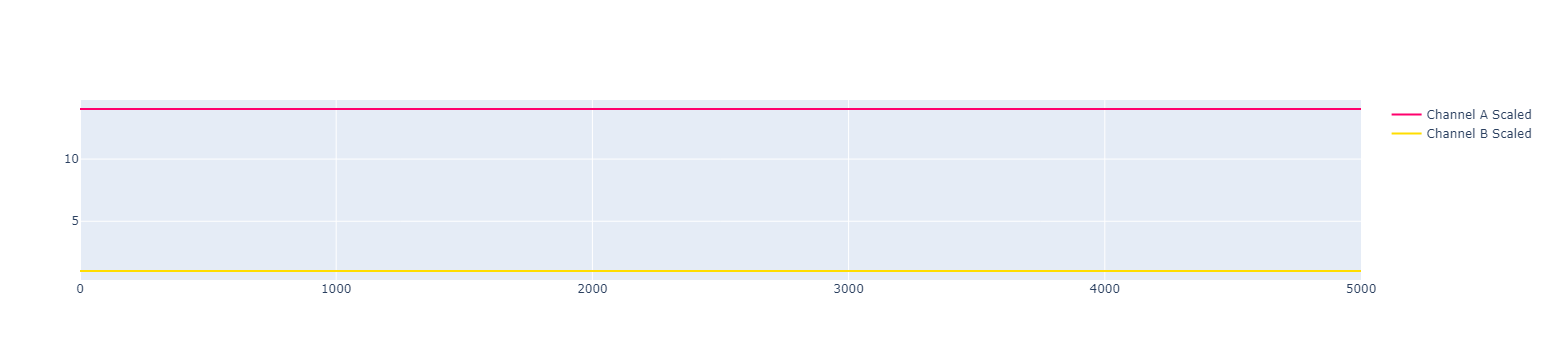

In [271]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=np.linspace(0, time_of_five_ms, num=1800),
        y=data['channel_a'],
        mode="lines",
        line=go.scatter.Line(color="#FF006D"),
        showlegend=True,
        name="Channel A Scaled")
)

fig.add_trace(
    go.Scatter(
        x=np.linspace(0, time_of_five_ms, num=1800),
        y=data['channel_b'],
        mode="lines",
        line=go.scatter.Line(color="#FFDD00"),
        showlegend=True,
        name="Channel B Scaled")
)

fig.show()